In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import torch
import time as time
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import compute_new_pose, poses_to_diff

In [2]:
# ------------------------------
# 🚚 Load V-JEPA 2 Model + Transforms
# ------------------------------

# Load pretrained encoder + predictor from Facebook Research Hub
encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")

encoder = encoder.to(device)
predictor = predictor.to(device)

# Define preprocessing transform (no randomness, center crop 256x256)
crop_size = 256
tokens_per_frame = int((crop_size // encoder.patch_size) ** 2)
transform = make_transforms(
    random_horizontal_flip=False,
    random_resize_aspect_ratio=(1., 1.),
    random_resize_scale=(1., 1.),
    reprob=0.,
    auto_augment=False,
    motion_shift=False,
    crop_size=crop_size,
)

Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main
/home/maddie/.conda/envs/vjepa2/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# ------------------------------
# 📦 Load Sample Trajectory (V-JEPA 2 Provided)
# ------------------------------

# Load example robot trajectory npz file
trajectory = np.load("franka_example_traj.npz")

# Extract image observations, robot states, and compute actions from states
np_clips = trajectory["observations"]   # shape: [B, T, H, W, C]
np_states = trajectory["states"]        # shape: [B, T, state_dim]
np_actions = np.expand_dims(poses_to_diff(np_states[0, 0], np_states[0, 1]), axis=(0, 1))  # [1, 1, 7]


In [4]:
# ------------------------------
# 🔁 Preprocess and Tensorize
# ------------------------------

# Apply V-JEPA 2 transform to input video [B=1, T=2, C, H, W]
clips = transform(np_clips[0]).unsqueeze(0).to(device)

# Convert states and actions to tensors
states = torch.tensor(np_states).to(device) 
actions = torch.tensor(np_actions).to(device)

current_state = states[:, 0, :]              # shape: [1, 7]
next_state = states[:, 1, :]                 # shape: [1, 7]
current_action = actions.squeeze(0).float()  # shape: [1, 7]

print(f"clips: {clips.shape}; current_state: {current_state.shape}; next_state: {next_state.shape}; current_action: {current_action.shape}")


clips: torch.Size([1, 3, 2, 256, 256]); current_state: torch.Size([1, 7]); next_state: torch.Size([1, 7]); current_action: torch.Size([1, 7])


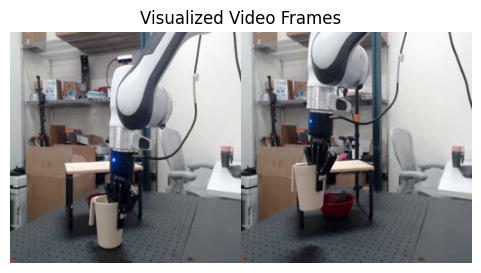

In [5]:
# ------------------------------
# 🖼️ Visualize All Frames
# ------------------------------

T = len(np_clips[0])
plt.figure(figsize=(20, 3))
_ = plt.imshow(np.transpose(np_clips[0], (1, 0, 2, 3)).reshape(256, 256 * T, 3))
plt.title("Visualized Video Frames")
plt.axis('off')
plt.show()


In [6]:
# ------------------------------
# 🔮 Latent Encoding + Prediction
# ------------------------------

def forward_target(c, normalize_reps=True):
    """Encode input clips into latent tokens using encoder."""
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h

def step_predictor(z_hat, a_hat, s_hat, normalize_reps=False):
    """Use the predictor to get predicted tokens and next state."""
    z_hat = predictor(z_hat, a_hat, s_hat)[:, -tokens_per_frame:]
    if normalize_reps:
        z_hat = F.layer_norm(z_hat, (z_hat.size(-1),))
    s_hat = compute_new_pose(s_hat[:, -1:], a_hat[:, -1:])
    return z_hat, s_hat

def loss_fn(z, h):
    """Simple L1 loss over predicted vs actual latent tokens."""
    z, h = z[:, -tokens_per_frame:], h[:, -tokens_per_frame:]
    loss = torch.abs(z - h)  # [B, N, D]
    return torch.mean(loss, dim=[1, 2]).tolist()


In [7]:
# ------------------------------
# ⚙️ Predict Next State + Tokens
# ------------------------------

# Disable gradients for eval
with torch.no_grad():
    start_time = time.time()
    h = forward_target(clips)  # [1, 512, D]
    
    print(f'Action: {current_action.unsqueeze(0).shape}')
    print(f'State: {current_state.unsqueeze(0).shape}')
    print(f'h shape: {h.shape}')

    z_hat, s_hat = step_predictor(
        h[:, :tokens_per_frame],                 # Encode only first frame
        current_action.unsqueeze(0).float().to(device),     # [1, 7]
        current_state.unsqueeze(0).float().to(device),      # [1, 7]
    )

    # end tracking time it takes to encode and predict
    end_time = time.time()
    print(f"Prediction time: {end_time - start_time:.4f} seconds")

Action: torch.Size([1, 1, 7])
State: torch.Size([1, 1, 7])
h shape: torch.Size([1, 512, 1408])
Prediction time: 0.2928 seconds


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [8]:
# ------------------------------
# 📉 Evaluate Prediction Quality
# ------------------------------

# Loss in Cartesian state space
mse_loss = torch.nn.functional.mse_loss(s_hat, next_state)
print(f"\n📉 MSE loss in state prediction: {mse_loss.item():.4f}")


loss = loss_fn(z_hat, h[:, tokens_per_frame:])
print(f"Loss in latent token prediction (L1): {loss[0]:.4f}")

# Cosine similarity across token dimension
cos_sim = F.cosine_similarity(z_hat, h[:, tokens_per_frame:], dim=-1)  # [B, N]
mean_cos_sim = cos_sim.mean().item()
print(f"Cosine similarity (mean over tokens): {mean_cos_sim:.4f}")



📉 MSE loss in state prediction: 0.0000
Loss in latent token prediction (L1): 0.6392
Cosine similarity (mean over tokens): 0.7301


/tmp/ipykernel_258449/2453890777.py:6: UserWarning: Using a target size (torch.Size([1, 7])) that is different to the input size (torch.Size([1, 1, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = torch.nn.functional.mse_loss(s_hat, next_state)
